# Comparison of Markowitz portfolio optimization classic and quantum algoritnms 

## 🚧 - This notebook is a work in progress - 🚧

The objective of this notebook is to compare  classic and quantum algoritms based on Markowitz portfolio optimization.

(http://en.wikipedia.org/wiki/Modern_portfolio_theory#The_efficient_frontier_with_no_risk-free_asset)

The portfolio optimizers will be backtested with real market data from IBEX35 Spanish shares historical data.

The scalability of the optimizers can be tested with different ammounts of elegible shares in the portfolio.

We assume the following simplifications:

* Binary decision: indicate which assets to pick and which not to pick. Once selected, all assests will weigh the same in the portfolio
* The number of assets to be selected out of 𝑛 will be fixed a priori (BUDGET).
* The optimization will be performend monthly with 3 months historical data, from 2017 to 2020.



## Install and initialize required software

Update to the last version of QISKit

In [ ]:
!pip install qiskit --upgrade

Install bt - Flexible Backtesting for Python
(http://pmorissette.github.io/bt/index.html)

In [ ]:
!pip install bt --upgrade

In [1]:
%matplotlib inline
%pylab inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Importing specific Qiskit libraries
from qiskit.circuit.library import RealAmplitudes
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.aqua.algorithms import VQE
from qiskit.aqua.components.optimizers import COBYLA

In [3]:
# Workaround for a bug in ffn
if 'DISPLAY' not in os.environ:
    os.environ['DISPLAY']="NONE"

In [4]:
import bt
import ffn
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from docplex.mp.model import Model
from math import log

In [6]:
import warnings
warnings.filterwarnings("ignore")

## Select and download shares historical data

From Yahoo Finance (https://es.finance.yahoo.com/quote/%5EIBEX/components?p=%5EIBEX)

In [7]:
# download data for IBEX 35
IBEX35='ELE.MC,ITX.MC,FER.MC,CLNX.MC,ANA.MC,ENG.MC,IBE.MC,BBVA.MC,ACS.MC,VIS.MC,MTS.MC,GRF.MC,COL.MC,REE.MC,ACX.MC,NTGY.MC,TEF.MC,SGRE.MC,SAN.MC,REP.MC,AMS.MC,BKT.MC,CABK.MC,ENC.MC,MAP.MC,AENA.MC,SAB.MC,MRL.MC,IAG.MC,MEL.MC'

all_data = bt.get(IBEX35, start='2016-01-01', end='2020-01-01')


In [8]:
# number of different shares to consider
SHARES = 5
# number of different shares to hold
BUDGET = 2


In [53]:
data = all_data.sample(n=SHARES, axis=1)

In [54]:
data.corr()

,tefmc,melmc,elemc,engmc,mapmc
tefmc,1.000000,0.722125,-0.301488,-0.128588,0.229702
melmc,0.722125,1.000000,-0.565980,-0.307612,0.230120
elemc,-0.301488,-0.565980,1.000000,0.356260,0.568095
engmc,-0.128588,-0.307612,0.356260,1.000000,-0.022781
mapmc,0.229702,0.230120,0.568095,-0.022781,1.000000


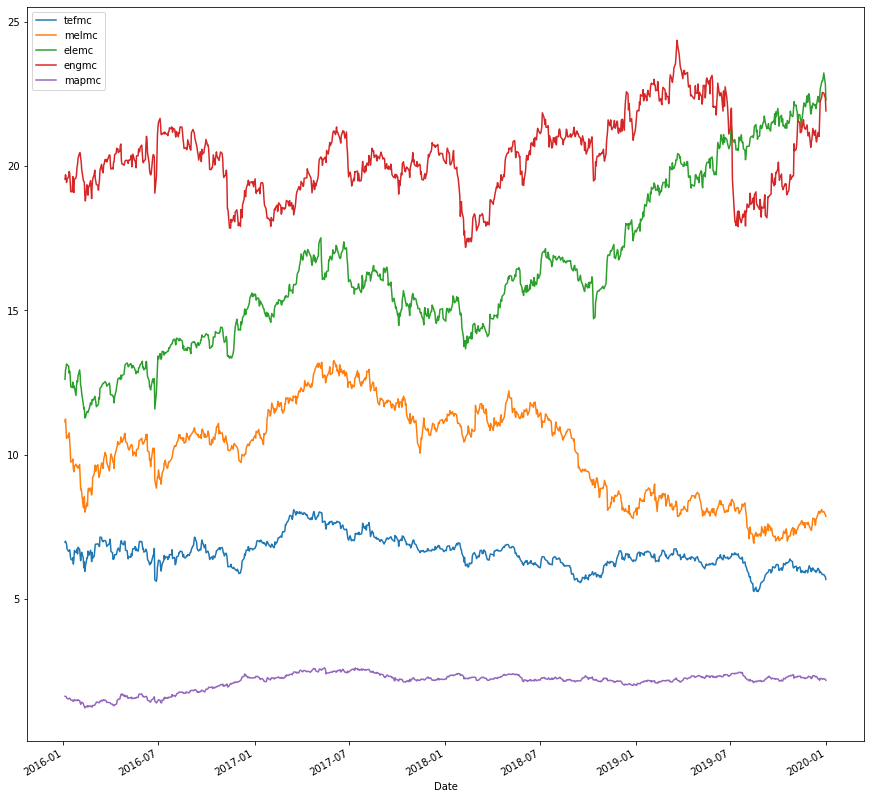

In [55]:
# let's see what the data looks like - this is by no means a pretty chart, but it does the job
plot = data.plot(figsize=(15, 15))

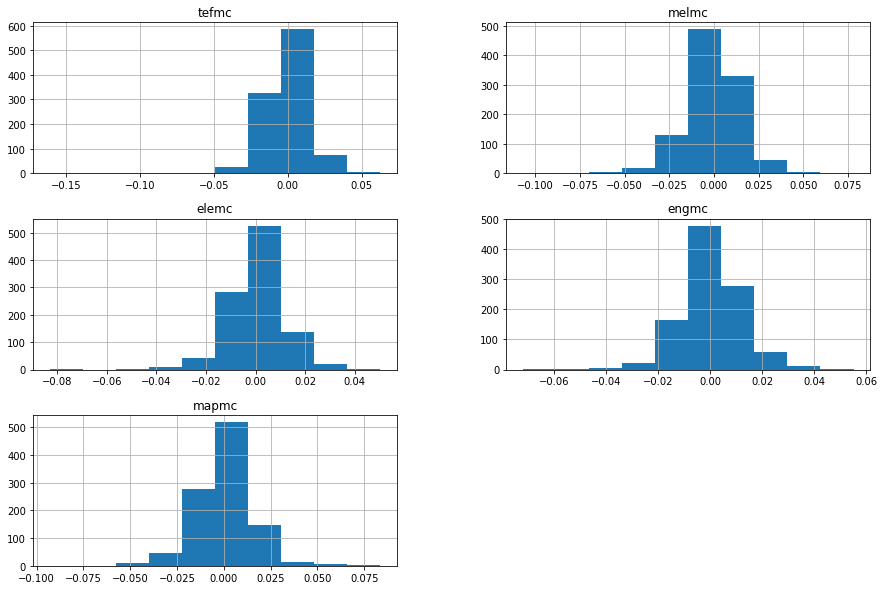

In [56]:
# now what do the return distributions look like?
returns = data.to_returns().dropna()
ax = returns.hist(figsize(15, 10))

## Classical Algoritm

### Mean-Variance optimization

Markowitz's mean-variance optimization (Sharpe ratio minimization) using scipy.optimize minimize

(Using http://pmorissette.github.io/bt/bt.html#module-bt.algos and https://pmorissette.github.io/ffn/)

In [57]:
class WeighMeanVar(bt.Algo):

    """
    Sets temp['weights'] based on mean-variance optimization.
    Sets the target weights based on ffn's calc_mean_var_weights. This is a
    Python implementation of Markowitz's mean-variance optimization.
    See:
        http://en.wikipedia.org/wiki/Modern_portfolio_theory#The_efficient_frontier_with_no_risk-free_asset
    Args:
        * lookback (DateOffset): lookback period for estimating volatility
        * bounds ((min, max)): tuple specifying the min and max weights for
            each asset in the optimization.
        * covar_method (str): method used to estimate the covariance. See ffn's
            calc_mean_var_weights for more details.
        * rf (float): risk-free rate used in optimization.
    Sets:
        * weights
    Requires:
        * selected
    """

    def __init__(self, lookback=pd.DateOffset(months=3),
                 bounds=(0., 1.), covar_method='ledoit-wolf',
                 rf=0., lag=pd.DateOffset(days=0)):
        super(WeighMeanVar, self).__init__()
        self.lookback = lookback
        self.lag = lag
        self.bounds = bounds
        self.covar_method = covar_method
        self.rf = rf

    def __call__(self, target):
        selected = target.temp['selected']

        if len(selected) == 0:
            target.temp['weights'] = {}
            return True

        if len(selected) == 1:
            target.temp['weights'] = {selected[0]: 1.}
            return True

        t0 = target.now - self.lag
        prc = target.universe[selected].loc[t0 - self.lookback:t0]
        tw = ffn.calc_mean_var_weights(
            prc.to_returns().dropna(), weight_bounds=self.bounds,
            covar_method=self.covar_method, rf=self.rf)

        target.temp['stat'] = pd.Series(tw.dropna())
        return True


In [58]:
# first we create the Strategy
classic_strategy_1 = bt.Strategy('classicOptimizer', [bt.algos.RunAfterDate('2017-01-01'),
                                      bt.algos.RunMonthly(),
                                      bt.algos.SelectAll(),
                                      WeighMeanVar(rf=0.5),
                                      bt.algos.SelectN(BUDGET),
                                      bt.algos.WeighEqually(),
                                      bt.algos.Rebalance()])

# now we create the Backtest
classic_test_1 = bt.Backtest(classic_strategy_1, data, progress_bar=True)

# and let's run it!
classic_ressult_1 = bt.run(classic_test_1)

classicOptimizer
0% [############################# ] 100% | ETA: 00:00:00

<AxesSubplot:title={'center':'Equity Progression'}>

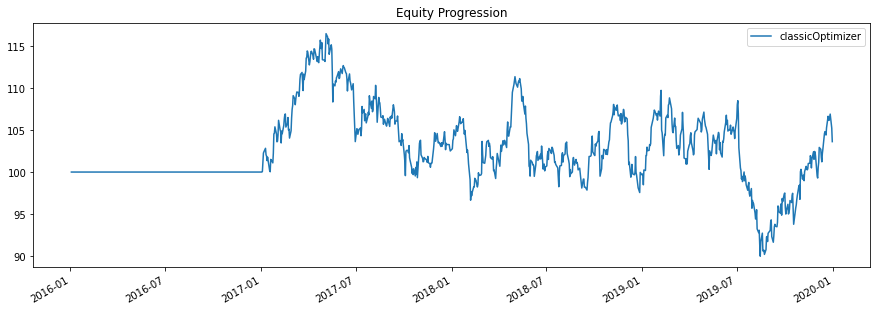

In [59]:
classic_ressult_1.plot()

In [60]:
# ok and what about some stats?
classic_ressult_1.display()

Stat                 classicOptimizer
-------------------  ------------------
Start                2016-01-03
End                  2019-12-31
Risk-free rate       0.00%

Total Return         3.62%
Daily Sharpe         0.13
Daily Sortino        0.21
CAGR                 0.89%
Max Drawdown         -22.75%
Calmar Ratio         0.04

MTD                  1.73%
3m                   6.38%
6m                   -1.30%
YTD                  3.96%
1Y                   3.96%
3Y (ann.)            1.20%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  0.89%

Daily Sharpe         0.13
Daily Sortino        0.21
Daily Mean (ann.)    1.81%
Daily Vol (ann.)     13.69%
Daily Skew           -0.15
Daily Kurt           2.33
Best Day             3.82%
Worst Day            -4.31%

Monthly Sharpe       0.13
Monthly Sortino      0.21
Monthly Mean (ann.)  1.67%
Monthly Vol (ann.)   12.41%
Monthly Skew         -0.39
Monthly Kurt         1.24
Best Month           8.03%
Worst Month          -9.87%


## Quantum Algoritm
### VQE optimization

Markowitz portfolio optimization. The resulting problem can be mapped to a Hamiltonian whose ground state corresponds to the optimal solution. The Variational Quantum Eigensolver (VQE) is used to find the optimal solution for a given set of parameters.

Here an Operator instance is created for our Hamiltonian. In this case the paulis are from an Ising Hamiltonian translated from the portfolio problem.

We can now use the Variational Quantum Eigensolver (VQE) to solve the problem. We will specify the optimizer and variational form to be used.

(Based on https://github.com/Qiskit/qiskit-tutorials/blob/master/tutorials/finance/01_portfolio_optimization.ipynb)


In [61]:
class StatVQE(bt.Algo):

    """
    Sets temp['stat'] based on VQE optimization.
    Implementre with QISKit.
    See:
        http://
    Args:
        * lookback (DateOffset): lookback period for estimating volatility
        * bounds ((min, max)): tuple specifying the min and max weights for
            each asset in the optimization.
        * covar_method (str): method used to estimate the covariance. See ffn's
            calc_mean_var_weights for more details.
        * rf (float): risk-free rate used in optimization.
        * budget(int): number of securities to select
    Sets:
        * weights
    Requires:
        * selected
    """

    def __init__(self, lookback=pd.DateOffset(months=3),
                 bounds=(0., 1.), covar_method='ledoit-wolf',
                 rf=0., lag=pd.DateOffset(days=0), budget=3):
        super(StatVQE, self).__init__()
        self.lookback = lookback
        self.lag = lag
        self.bounds = bounds
        self.covar_method = covar_method
        self.rf = rf
        self.budget = budget 
             

    def __call__(self, target):
        selected = target.temp['selected']

        if len(selected) == 0:
            target.temp['stat'] = {}
            return True

        if len(selected) == 1:
            target.temp['stat'] = {selected[0]: 1.}
            return True

        t0 = target.now - self.lag
        prc = target.universe[selected].loc[t0 - self.lookback:t0]
        
        # Generate expected return and covariance matrix from time-series
        
        rets = prc.to_returns().dropna()
        mu = rets.mean().values
        sigma = rets.cov().values


        # create docplex model
        mdl = Model('portfolio_optimization')
        x = mdl.binary_var_list('x{}'.format(i) for i in range(n))
        objective = mdl.sum([mu[i]*x[i] for i in range(n)])
        objective -= q * mdl.sum([sigma[i,j]*x[i]*x[j] for i in range(n) for j in range(n)])
        mdl.maximize(objective)
        mdl.add_constraint(mdl.sum(x[i] for i in range(n)) == budget)

        # import the classical optimizer
        from qiskit.aqua.components.optimizers import COBYLA

        optim_dict = {
        "docplex_mod": mdl,
        "quantum_instance": 'qasm_simulator',
        "shots": 1024,
        "print": True,
        "solver":'vqe',
        "optimizer":COBYLA,
        "maxiter":100,
        "depth":1,
        "alpha":0.35
        }
        
        # Call the aggregator with 'optimizer' as the algorithm of choice
        results = aggregator('optimizer', optim_dict)

        rw = np.array(list(results['result'].variables_dict.values())).astype(int)
        
        target.temp['stat'] = pd.Series(dict(list(zip(selected, rw))))
        return True


In [62]:
# first we create the Strategy

quantum_strategy_1 = bt.Strategy('quantumOptimizer', [bt.algos.RunAfterDate('2017-01-01'),
                                      bt.algos.RunMonthly(),
                                      bt.algos.SelectAll(),
                                      StatVQE(rf=0.5, budget=BUDGET),
                                      bt.algos.SelectN(BUDGET),
                                      bt.algos.WeighEqually(),
                                      bt.algos.Rebalance()])

# now we create the Backtest
quantum_test_1 = bt.Backtest(quantum_strategy_1, data, progress_bar=True)

# and let's run it!
quantum_result_1 = bt.run(quantum_test_1)

quantumOptimizer
0% [############################# ] 100% | ETA: 00:00:06

<AxesSubplot:title={'center':'Equity Progression'}>

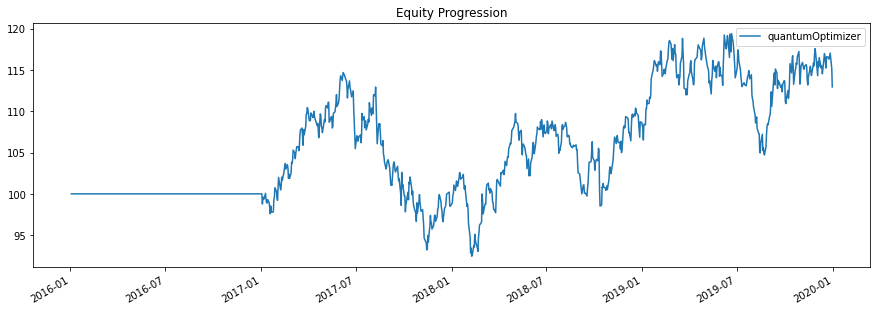

In [63]:
quantum_result_1.plot()

In [64]:
quantum_result_1.display()

Stat                 quantumOptimizer
-------------------  ------------------
Start                2016-01-03
End                  2019-12-31
Risk-free rate       0.00%

Total Return         12.94%
Daily Sharpe         0.29
Daily Sortino        0.49
CAGR                 3.10%
Max Drawdown         -19.38%
Calmar Ratio         0.16

MTD                  -3.56%
3m                   -0.67%
6m                   -0.96%
YTD                  3.97%
1Y                   3.97%
3Y (ann.)            4.15%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  3.10%

Daily Sharpe         0.29
Daily Sortino        0.49
Daily Mean (ann.)    3.85%
Daily Vol (ann.)     13.07%
Daily Skew           0.15
Daily Kurt           2.15
Best Day             4.05%
Worst Day            -4.21%

Monthly Sharpe       0.33
Monthly Sortino      0.61
Monthly Mean (ann.)  3.72%
Monthly Vol (ann.)   11.21%
Monthly Skew         0.14
Monthly Kurt         -0.37
Best Month           6.35%
Worst Month          -6.39

## Comparison

Stat                 classicOptimizer    quantumOptimizer
-------------------  ------------------  ------------------
Start                2016-01-03          2016-01-03
End                  2019-12-31          2019-12-31
Risk-free rate       0.00%               0.00%

Total Return         3.62%               12.94%
Daily Sharpe         0.13                0.29
Daily Sortino        0.21                0.49
CAGR                 0.89%               3.10%
Max Drawdown         -22.75%             -19.38%
Calmar Ratio         0.04                0.16

MTD                  1.73%               -3.56%
3m                   6.38%               -0.67%
6m                   -1.30%              -0.96%
YTD                  3.96%               3.97%
1Y                   3.96%               3.97%
3Y (ann.)            1.20%               4.15%
5Y (ann.)            -                   -
10Y (ann.)           -                   -
Since Incep. (ann.)  0.89%               3.10%

Daily Sharpe         0.13   

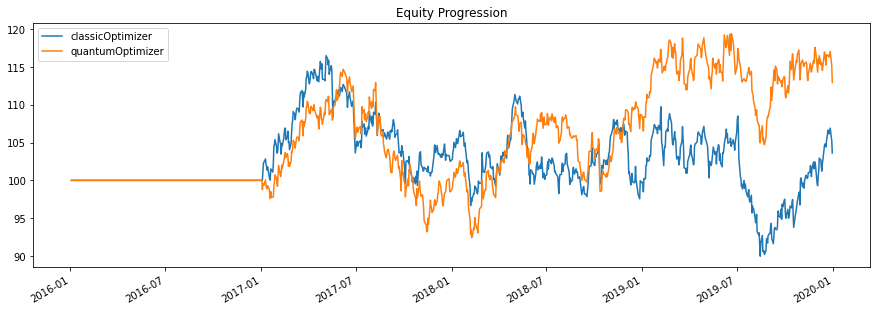

In [65]:
results_comparison = bt.run(classic_test_1,quantum_test_1)
results_comparison.plot()
results_comparison.display()

In [66]:
import qiskit.tools.jupyter
%qiskit_version_table